In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [5]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import scipy.stats as stats
from scipy.stats import boxcox

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import (
    SelectKBest,
    f_classif,
    f_regression,
    mutual_info_regression,
)
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [55]:
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "useducation"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

df = pd.read_sql_query("select * from {}".format(postgres_db), con=engine)

# no need for an open connection,
# as we're only doing a single query
engine.dispose()

<IPython.core.display.Javascript object>

In [6]:
df.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN


<IPython.core.display.Javascript object>

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PRIMARY_KEY                   1492 non-null   object 
 1   STATE                         1492 non-null   object 
 2   YEAR                          1492 non-null   int64  
 3   ENROLL                        1229 non-null   float64
 4   TOTAL_REVENUE                 1280 non-null   float64
 5   FEDERAL_REVENUE               1280 non-null   float64
 6   STATE_REVENUE                 1280 non-null   float64
 7   LOCAL_REVENUE                 1280 non-null   float64
 8   TOTAL_EXPENDITURE             1280 non-null   float64
 9   INSTRUCTION_EXPENDITURE       1280 non-null   float64
 10  SUPPORT_SERVICES_EXPENDITURE  1280 non-null   float64
 11  OTHER_EXPENDITURE             1229 non-null   float64
 12  CAPITAL_OUTLAY_EXPENDITURE    1280 non-null   float64
 13  GRA

<IPython.core.display.Javascript object>

In [8]:
df["ratio_8_to_4"] = df["GRADES_8_G"] / df["GRADES_4_G"]

<IPython.core.display.Javascript object>

In [10]:
df["avg_overall"] = (
    (((df["AVG_MATH_8_SCORE"] + df["AVG_MATH_8_SCORE"]) / 2) * df["ratio_8_to_4"])
    + ((df["AVG_MATH_4_SCORE"] + df["AVG_MATH_4_SCORE"]) / 2)
) / 2

<IPython.core.display.Javascript object>

In [11]:
df["avg_overall"]

0       230.425250
1              NaN
2       225.106106
3       238.362062
4       217.460752
           ...    
1487           NaN
1488           NaN
1489           NaN
1490           NaN
1491           NaN
Name: avg_overall, Length: 1492, dtype: float64

<IPython.core.display.Javascript object>

In [26]:
expend_cols = [
    "INSTRUCTION_EXPENDITURE",
    "SUPPORT_SERVICES_EXPENDITURE",
    "OTHER_EXPENDITURE",
    "CAPITAL_OUTLAY_EXPENDITURE",
    "avg_overall",
]

df[expend_cols].corr()
# total and support services but non are super highly correlated

,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,avg_overall
INSTRUCTION_EXPENDITURE,1.000000,0.976889,0.909340,0.896103,0.096142
SUPPORT_SERVICES_EXPENDITURE,0.976889,1.000000,0.953091,0.917782,0.098327
OTHER_EXPENDITURE,0.909340,0.953091,1.000000,0.921932,-0.004175
CAPITAL_OUTLAY_EXPENDITURE,0.896103,0.917782,0.921932,1.000000,0.037359
avg_overall,0.096142,0.098327,-0.004175,0.037359,1.000000


<IPython.core.display.Javascript object>

In [27]:
target_df = df[expend_cols].dropna()

<IPython.core.display.Javascript object>

In [28]:
X = target_df.drop(columns="avg_overall")
y = target_df["avg_overall"]

<IPython.core.display.Javascript object>

In [29]:
scaler = StandardScaler()

# 'learn' from the data
scaler.fit(X)

# apply what the scaler learned
scaled_X = scaler.transform(X)
scaled_df = pd.DataFrame(scaled_X, columns=X.columns)


<IPython.core.display.Javascript object>

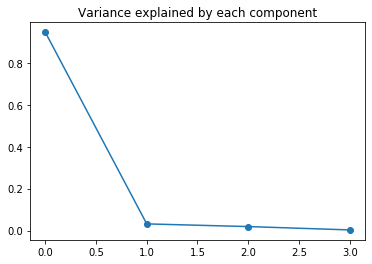

<IPython.core.display.Javascript object>

In [30]:
pca = PCA()

# 'learn' from the data
pca.fit(scaled_X)

# apply what the pca object learned
pca_X = pca.transform(scaled_X)

# What attribute holds the variance explained?
plt.plot(pca.explained_variance_ratio_, marker="o")
plt.title("Variance explained by each component")
plt.show()


In [41]:
pd.concat((pd.DataFrame(pca_X), target_df["avg_overall"]), axis=1).

,0,1,2,3,avg_overall
0,-0.909797,-0.076093,0.181789,0.127318,NaN
1,-1.369359,-0.066110,-0.108569,0.001110,NaN
2,-0.773548,-0.291904,-0.162020,0.002009,NaN
3,-1.201728,-0.038431,-0.022698,0.035737,NaN
4,3.861234,-0.031225,1.560322,0.502821,NaN
5,-0.932675,-0.111978,-0.168141,-0.006270,NaN
6,-1.004540,0.160332,-0.023483,0.014236,NaN
7,-1.439331,-0.041598,-0.068443,0.011462,NaN
8,-1.452665,-0.021906,-0.033580,-0.008371,NaN
9,1.037033,-0.519374,0.298701,0.077434,NaN


<IPython.core.display.Javascript object>

In [46]:
stats.pearsonr(pca_X[:, 0], y)

(0.026943986797132106, 0.5734131771307325)

<IPython.core.display.Javascript object>

In [56]:
df["GRADES_8_G"].sum() - df["GRADES_4_G"].sum()

-364571.0

<IPython.core.display.Javascript object>

In [64]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

edu_df = df.copy()
edu_df = edu_df.dropna()
X = edu_df[
    [
        "INSTRUCTION_EXPENDITURE",
        "SUPPORT_SERVICES_EXPENDITURE",
        "OTHER_EXPENDITURE",
        "CAPITAL_OUTLAY_EXPENDITURE",
    ]
]

X = StandardScaler().fit_transform(X)

sklearn_pca = PCA(n_components=1)
edu_df["pca_1"] = sklearn_pca.fit_transform(X)

print(
    "The percentage of total variance in the dataset explained by each",
    "component from Sklearn PCA.\n",
    sklearn_pca.explained_variance_ratio_,
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.94312987]


<IPython.core.display.Javascript object>

In [61]:
X.max()

nan

<IPython.core.display.Javascript object>

In [65]:
(46 + 42) / (46 + 42 + 21 + 17)

0.6984126984126984

<IPython.core.display.Javascript object>